In [644]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [645]:
df = pd.read_csv('complete_history_store1.csv')
df.head()

,timestamp,HVAC_Energy(t),Refrigeration_Energy(t),Lighting_Energy(t),IT_System(t),Other_System(t),Electricity_Price(t),Solar_Available_for_Use(t),Solar_Used_to_Charge_Battery(t),Base_Consumption_Loads(t),Total_Energy(t),Battery_1_Charge_Discharge(t),Battery_1_Energy_Stored(t),Battery_2_Charge_Discharge(t),Battery_2_Energy_Stored(t)
0,2022-01-01 00:00:00,111.226592,196.685501,0.000000,69.532528,50.049217,0.065712,0.0,0.0,427.493838,427.493838,-39.959290,171.316403,-39.515056,210.604568
1,2022-01-01 01:00:00,89.005608,206.330939,2.548394,55.134340,42.159803,0.062687,0.0,0.0,395.179084,395.179084,-21.790335,148.379208,-21.999100,187.447621
2,2022-01-01 02:00:00,115.423028,200.257985,0.000000,46.503376,44.013516,0.065485,0.0,0.0,406.197906,406.197906,-31.722753,114.986836,-31.018854,154.796196
3,2022-01-01 03:00:00,95.907992,182.592128,0.405717,42.987014,32.565693,0.061437,0.0,0.0,354.458544,354.458544,-21.640861,92.206983,-21.541469,132.120966
4,2022-01-01 04:00:00,100.240215,184.117794,0.000000,45.160155,31.403503,0.067825,0.0,0.0,360.921667,360.921667,-18.217019,73.031173,-18.019729,113.152830


In [646]:
target = 'Base_Consumption_Loads(t)'

In [647]:
df = df[['timestamp', target]]
df = df.set_index('timestamp')

In [648]:
df.index = pd.to_datetime(df.index)
df.head()

,Base_Consumption_Loads(t)
timestamp,
2022-01-01 00:00:00,427.493838
2022-01-01 01:00:00,395.179084
2022-01-01 02:00:00,406.197906
2022-01-01 03:00:00,354.458544
2022-01-01 04:00:00,360.921667


In [649]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30241 entries, 2022-01-01 00:00:00 to 2025-06-14 00:00:00
Data columns (total 1 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Base_Consumption_Loads(t)  30241 non-null  float64
dtypes: float64(1)
memory usage: 472.5 KB


<Axes: title={'center': 'Base_Consumption_Loads(t)'}, xlabel='timestamp'>

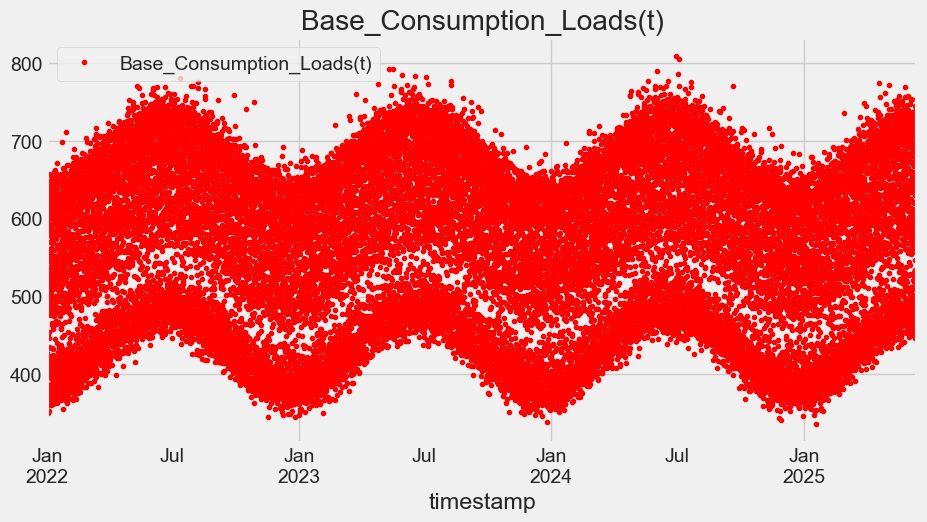

In [650]:
df.plot(style='.', figsize=(10,5), color='r', title=target)

Outlier Removal

<Axes: ylabel='Frequency'>

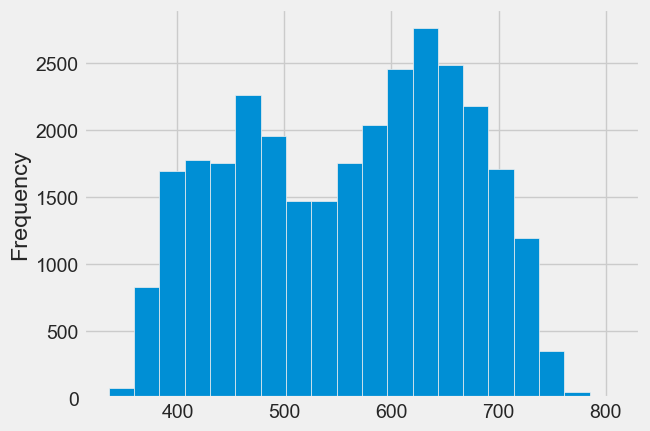

In [636]:
df[target].plot(kind='hist', bins=20)

<Axes: title={'center': 'Outliers'}, xlabel='timestamp'>

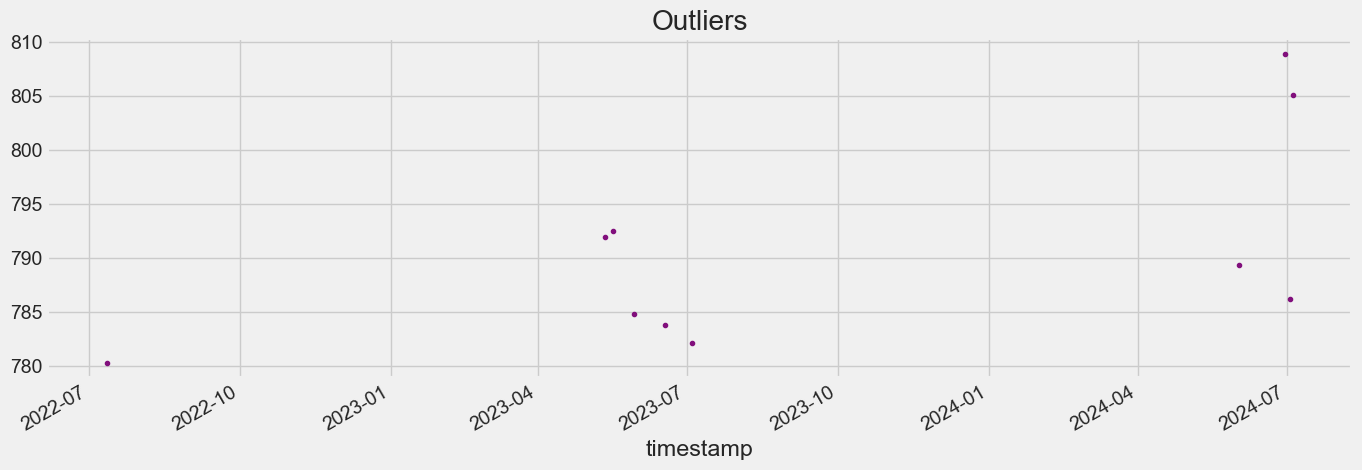

In [640]:
df.query(f'`{target}` > 780')[target] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

In [642]:
# df = df.query(f'`{target}` > 780').copy()

Train-test split

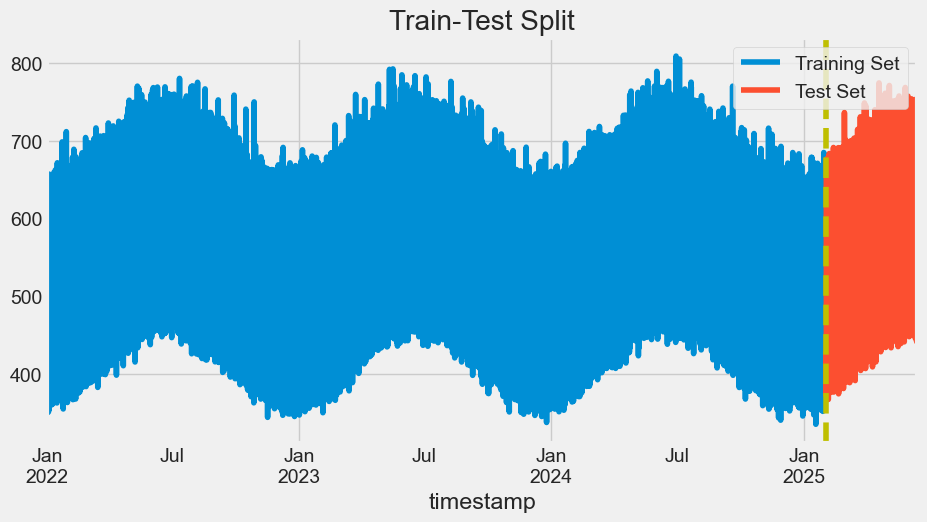

In [651]:
train = df.loc[df.index<'02-02-2025']
test = df.loc[df.index>='02-02-2025']

fig, ax = plt.subplots(figsize=(10,5))
train.plot(ax=ax, label='Training Set', title='Train-Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('02-02-2025', color='y', linestyle='--', linewidth=4)
ax.legend(['Training Set', 'Test Set'])
plt.show()

Features

In [652]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    return df

df = create_features(df)

In [653]:
df.head()

,Base_Consumption_Loads(t),hour,dayofweek,quarter,month,dayofyear,dayofmonth
timestamp,,,,,,,
2022-01-01 00:00:00,427.493838,0,5,1,1,1,1
2022-01-01 01:00:00,395.179084,1,5,1,1,1,1
2022-01-01 02:00:00,406.197906,2,5,1,1,1,1
2022-01-01 03:00:00,354.458544,3,5,1,1,1,1
2022-01-01 04:00:00,360.921667,4,5,1,1,1,1


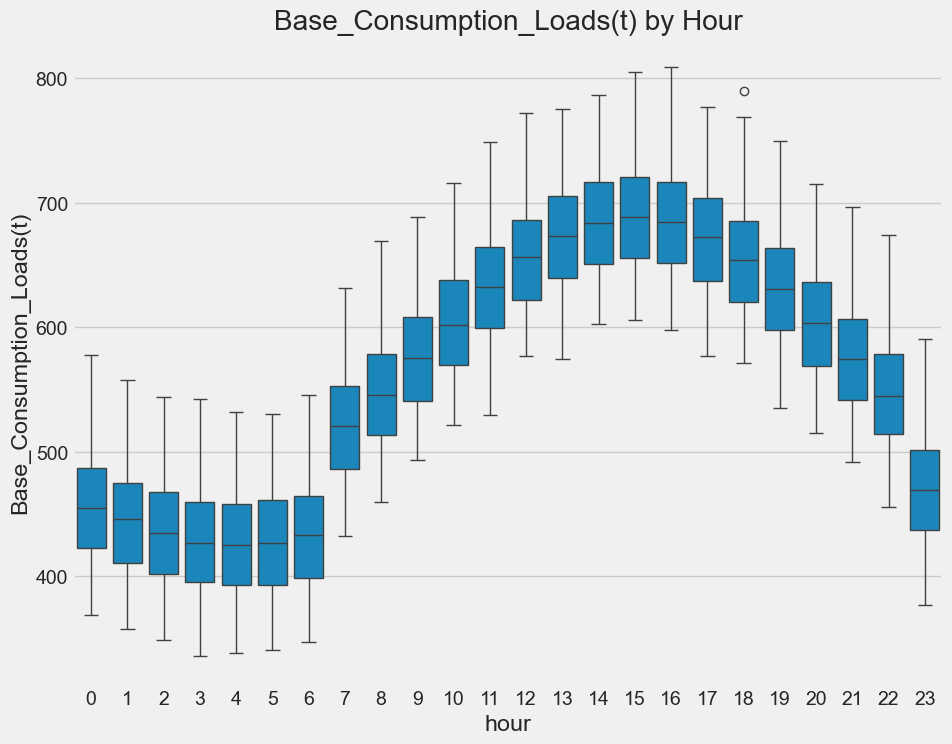

In [654]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(x='hour', y=target, data=df)
ax.set_title(f'{target} by Hour')
plt.show()

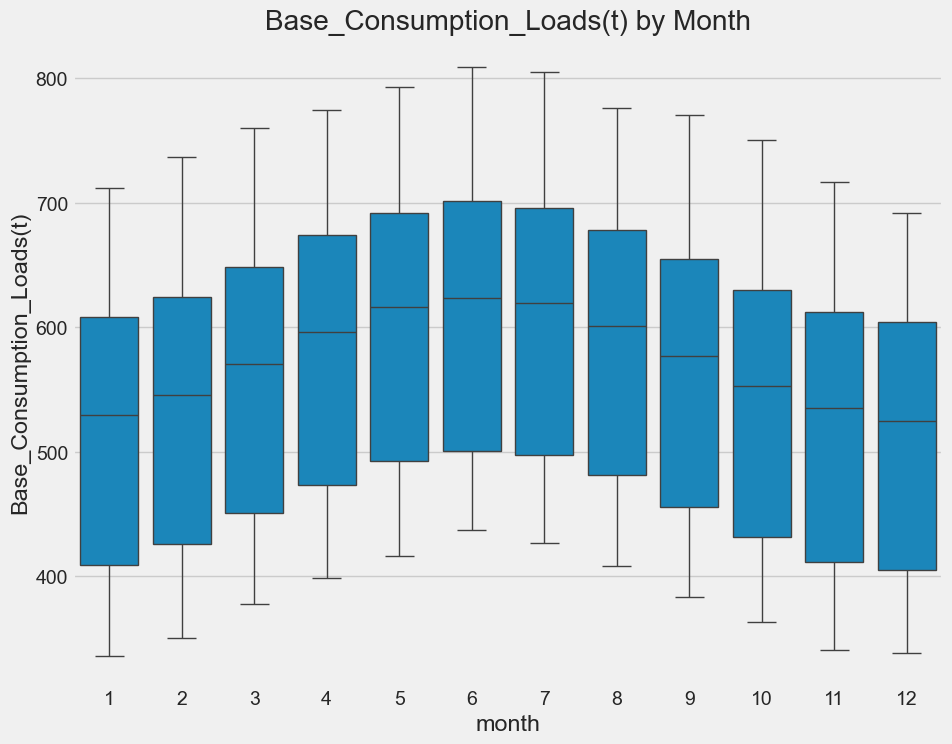

In [655]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(x='month', y=target, data=df)
ax.set_title(f'{target} by Month')
plt.show()

Create the model

In [656]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month']
TARGET = target

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [660]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       max_depth=5,
                       learning_rate=0.007)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:564.40358	validation_1-rmse:577.65900
[100]	validation_0-rmse:280.77483	validation_1-rmse:289.17515
[200]	validation_0-rmse:140.35466	validation_1-rmse:145.46836
[300]	validation_0-rmse:71.31292	validation_1-rmse:74.15809
[400]	validation_0-rmse:38.18734	validation_1-rmse:39.78382
[500]	validation_0-rmse:23.49309	validation_1-rmse:24.31628
[600]	validation_0-rmse:17.95828	validation_1-rmse:18.43090
[700]	validation_0-rmse:16.23286	validation_1-rmse:16.57345
[800]	validation_0-rmse:15.73493	validation_1-rmse:16.06379
[900]	validation_0-rmse:15.58363	validation_1-rmse:15.92720
[999]	validation_0-rmse:15.52951	validation_1-rmse:15.89498


,objective,'reg:squarederror'
,base_score,0.5
,booster,'gbtree'
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,None


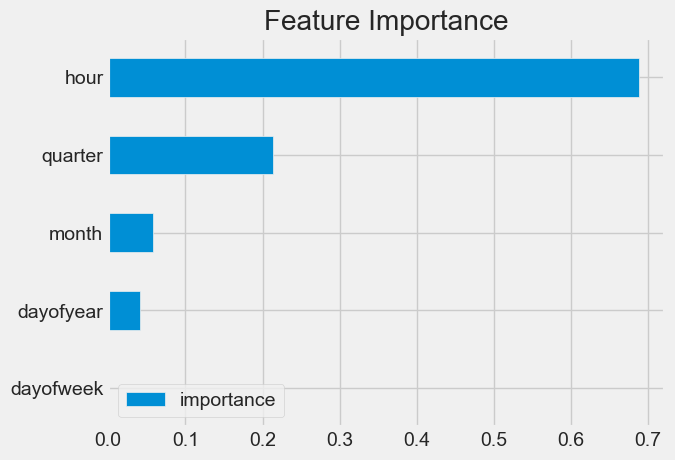

In [661]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

Forecast on test

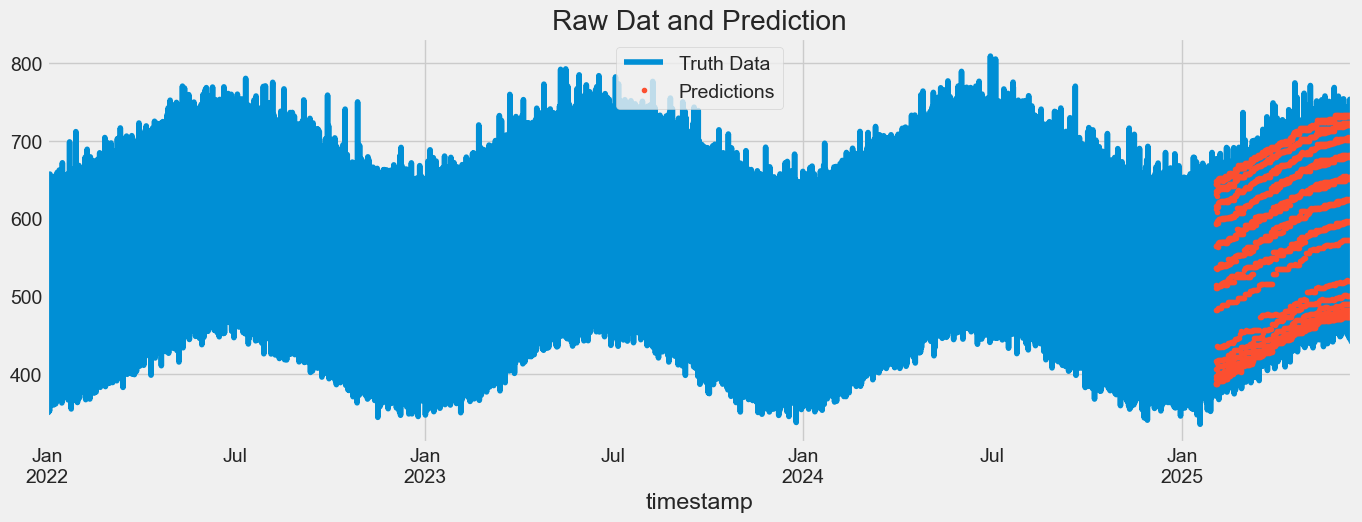

In [662]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[[target]].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

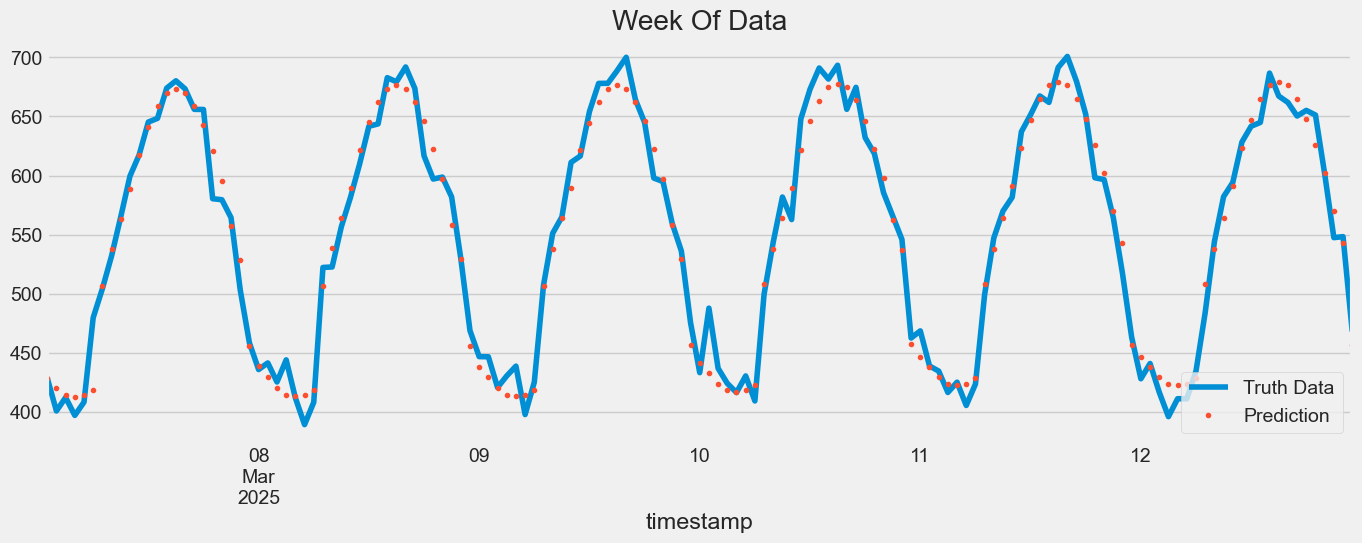

In [663]:
ax = df.loc[(df.index > '03-07-2025') & (df.index < '03-13-2025')][target] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '03-07-2025') & (df.index < '03-13-2025')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [664]:
score = np.sqrt(mean_squared_error(test[target], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 15.89


In [665]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2025-04-19    18.702636
2025-02-19    17.809556
2025-04-27    16.222418
2025-05-13    16.092151
2025-04-07    15.933388
2025-02-06    15.450939
2025-04-28    15.326634
2025-02-12    15.230292
2025-05-01    15.123134
2025-04-21    15.060197
Name: error, dtype: float64

In [666]:
from sklearn.metrics import r2_score

r2 = r2_score(test[target], test['prediction'])
print(f'R² Score on Test set: {r2:.2f}')

R² Score on Test set: 0.98


In [667]:
# Save model
reg.save_model(f'{target}_model.json')

In [275]:
reg_new = xgb.XGBRegressor()
reg_new.load_model(f'{target}_model.json')
df_pred = reg_new.predict(X_test)

In [276]:
print(df_pred)

[498.00888   498.00888   498.007     ...  41.694347   19.632376
   1.6878434]


In [277]:
ds = test['prediction']

In [278]:
ds.head(20)

timestamp
2024-08-06 00:00:00    498.008881
2024-08-06 01:00:00    498.008881
2024-08-06 02:00:00    498.006989
2024-08-06 03:00:00    498.006989
2024-08-06 04:00:00    497.995422
2024-08-06 05:00:00    497.995422
2024-08-06 06:00:00    497.995422
2024-08-06 07:00:00    497.995422
2024-08-06 08:00:00    497.995422
2024-08-06 09:00:00    498.073853
2024-08-06 10:00:00    498.073517
2024-08-06 11:00:00    498.113647
2024-08-06 12:00:00    498.113647
2024-08-06 13:00:00    498.119202
2024-08-06 14:00:00    498.143127
2024-08-06 15:00:00    498.143127
2024-08-06 16:00:00    498.143127
2024-08-06 17:00:00    498.143127
2024-08-06 18:00:00    498.143127
2024-08-06 19:00:00    498.143127
Name: prediction, dtype: float32

In [628]:
X_test

,dayofyear,hour,dayofweek,quarter,month
timestamp,,,,,
2025-02-02 00:00:00,33,0,6,1,2
2025-02-02 01:00:00,33,1,6,1,2
2025-02-02 02:00:00,33,2,6,1,2
2025-02-02 03:00:00,33,3,6,1,2
2025-02-02 04:00:00,33,4,6,1,2
...,...,...,...,...,...
2025-06-13 20:00:00,164,20,4,2,6
2025-06-13 21:00:00,164,21,4,2,6
2025-06-13 22:00:00,164,22,4,2,6
